In [5]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=252647ccbaa19c6514ffdae4d0018eb6066258971a6f5378a00344b424715e58
  Stored in directory: /tmp/pip-ephem-wheel-cache-onbzgx18/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


In [2]:
!pip install -q transformers  rouge-score sentence-transformers

In [2]:
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm

import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt

import os 

nlp = spacy.load('en_core_web_lg')
os.makedirs("data", exist_ok=True)
sum_dir = "drive/MyDrive/mlexperiments/extractivesummarization/"
cnn_df = pd.read_json(sum_dir + "data/test/test.json") 

## Model Architecture 

- Get representations for documents and sentences
- Train a classification head to predict if each sentence belongs in a summary. 

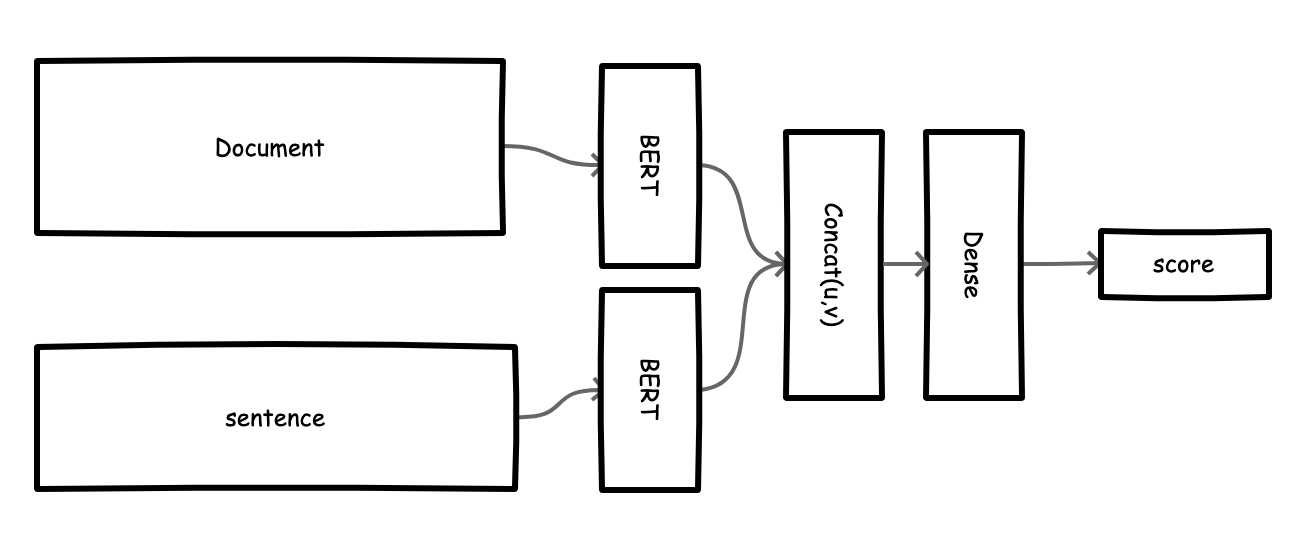

## Extracting Sentence Embeddigns via Mean Pooling

- We use sentence embedding models hosted in HuggingFace and use mean pooling of each token sentence representation. 

Source: https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")
sentence_model = AutoModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")



#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


def get_sentence_embedding(sentences):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
      model_output = sentence_model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings

#Sentences we want sentence embeddings for
sentences = ['This framework generates embeddings for each input sentence',
             'Sentences are passed as a list of string.',
             'Twitter is rolling out changes to its newly rebuilt API that will allow third-party developers to build tools and other solutions specifically for its audio chatroom product, Twitter Spaces. The company today announced it’s shipping new endpoints to support Spaces on the Twitter API v2, with the initial focus on enabling discovery of live or scheduled Spaces. This may later be followed by an API update that will make it possible for developers to build out more tools for Spaces’ hosts.With the current API update, Twitter hopes developers will build new products that enable users — both on and off Twitter — to find Twitter Spaces more easily, the company says. This could potentially broaden the reach of Spaces and introduce its audio chats to more people, which could give Twitter a leg up in the increasingly competitive landscape for audio-based social networking. Today, Twitter Spaces isn’t only taking on Clubhouse, but also the audio chat experiences being offered by Facebook, Discord, Reddit, Public.com, Spotify and smaller social apps.']




In [7]:
%time
semmb = get_sentence_embedding(sentences)
semmb.shape

torch.Size([300, 384])

## Create Data Pipeline

In [23]:
def get_dicts(df, folder="test"):   
  sents_dict = {}
  doc_dict = { i: {"article": df.article[i], "highlight": df.highlights[i]} for i in df.index }
  raw_docs = [ doc_dict[k]["article"] for k in doc_dict.keys()]

  doc_sents = {}
  sents_list = []
  raw_sents = [] 
  i = 0
  min_sent_length = 14
  for k in tqdm(doc_dict.keys()):
    article = doc_dict[k]["article"]  
    sents = nlp(article).sents
    doc_sent_ids = [] 
    for sent in sents:
      if (len(sent)) > min_sent_length:
        sents_dict[i] = {"docid":k, "text": str(sent)} 
        sents_list.append({"sentid":i, "docid":k, "text": str(sent) }) 
        raw_sents.append(str(sent))
        i += 1  
  return doc_dict, sents_list

  

In [24]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(cnn_df, test_size=0.2, random_state=42)
print(train_df.shape, test_df.shape)

test_doc_dict, test_sents_list = get_dicts(test_df)
train_doc_dict, train_sents_list = get_dicts(train_df)

(9192, 2) (2298, 2)


  0%|          | 0/2298 [00:00<?, ?it/s]

  0%|          | 0/9192 [00:00<?, ?it/s]

In [25]:
from rouge_score import rouge_scorer 
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def get_rougue_score(text, highlights, metric="rougeL"):
  max_score = 0
  for h_text in highlights:
    score =  scorer.score(text, h_text)[metric].fmeasure
    # print(score, text, "\n \t" , h_text)
    if score > max_score:
      max_score = score 
  return max_score 


def get_label(sent, doc_dict,  score_threshold = 0.55):
  sent_id, doc_id, sentence = sent["sentid"], sent["docid"], sent["text"]  
  highlights = doc_dict[doc_id]["highlight"].split("\n")
  doc = doc_dict[doc_id]["article"]

  label_score = get_rougue_score(sentence, highlights) 
  # Normalize label to 0/1 based on rogue score threshold
  label_score = 0 if label_score < score_threshold else 1 
  return (sentence, doc, label_score)
  

In [26]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, doc_dict, sents_list):
        'Initialization'
        self.sents = sents_list
        self.doc_dict = doc_dict 


  def __len__(self):
        'Denotes the total number of samples'
        return len(self.sents)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x1, x2, y = get_label( self.sents[index], self.doc_dict)

        embs =  get_sentence_embedding([x1,x2])
        x1,x2 = embs[0], embs[1]
        X=(x1,x2)

        return X, y

In [28]:
def get_batched_vals(sents_batch):
    vals = [get_label(x, train_doc_dict)  for x in sents_batch] 
    
    sents, docs, y = [], [], [] 
    for row in vals:
      sents.append(row[0])
      docs.append(row[1])
      y.append(row[2])
       
    
    return sents, docs, y

## Get Class Weights 

There are multiple approaches to handing class imbalance. 

- Undersample majority class
- SMOTE 
- Weighted loss function. 




In [29]:
s,d, y = get_batched_vals(train_sents_list)

train_labels_ohe = keras.utils.to_categorical(y)
class_totals = train_labels_ohe.sum(axis=0)
class_weight = dict()

for i in range(0, len(class_totals)):
	class_weight[i] = class_totals.max() / class_totals[i]
class_weight

{0: 1.0, 1: 25.604918}

In [30]:
class Net(nn.Module):

    def __init__(self, in_features=384):
        super(Net, self).__init__()
        
        # classification head that accepts text features

        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features*3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),

            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, doc_feats, sentence_feats):
        
        # Multiply (element-wise) the feature vectors of the two images together, 
        # to generate a combined feature vector representing the similarity between the two.
        combined_features = doc_feats * sentence_feats  

        # get concat of both features and elementwise product
        x = torch.cat((doc_feats, sentence_feats, combined_features), dim=1) 

        output = self.cls_head(x)

        # print(output.shape)
        return output

## Train a model

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


model = Net() 

losses = []
correct = 0
total = 0 


# Set device to CUDA if a CUDA device is available, else CPU. Copy model to selected device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Cuda is available?", torch.cuda.is_available())
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss() # 
criterion = torch.nn.BCELoss()


writer = SummaryWriter(os.path.join("", "summary"))

batch_size = 64
n_epochs = 2
n_batches = int( len(train_sents_list) / batch_size)

for epoch in range(n_epochs):
  print("Epoch ... [{} / {}]".format(epoch, n_epochs))
  model.train()

  losses = []
  correct = 0
  total = 0

  for i in tqdm(range(n_batches)):
    # sentence, document, y = get_label(sent, train_doc_dict)
    batch_start = i*batch_size
    batch_end = (i+1)*batch_size

    sent_batch = train_sents_list[batch_start:batch_end]
    sentences, docs, y = get_batched_vals(sent_batch)

    loss_weights = [ class_weight[label] for label in y] 
    # print(y, "\n", loss_weights)
    loss_weights = torch.FloatTensor(loss_weights)

    # get embeddings for docss and sentences 
    sentences = get_sentence_embedding(sentences)
    docs = get_sentence_embedding(docs)
    y = torch.reshape(torch.FloatTensor(y), (-1,1))
    # y =  torch.LongTensor(y)
   

    sentences, docs, y, loss_weights = map(lambda x: x.to(device), [sentences, docs, y, loss_weights])

    # get model prediction
    prob = model(sentences, docs) 
    loss = criterion(prob, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    correct += torch.count_nonzero(y == (prob > 0.5)).item()
    total += len(y)
    print("Batch | ", str(i), "of", str(n_batches), "loss -> ", loss.item() , "acc ->", round(correct/total,4) )

  writer.add_scalar('train_loss', sum(losses)/len(losses), epoch)
  writer.add_scalar('train_acc', correct / total, epoch)

  print("\tTraining: Loss={:.2f}\t Accuracy={:.2f}\t".format(sum(losses)/len(losses), correct / total))
        

Cuda is available? True
Epoch ... [0 / 2]


  0%|          | 0/3770 [00:00<?, ?it/s]

Batch |  0 of 3770 loss ->  0.6237705945968628 acc -> 0.67
Batch |  1 of 3770 loss ->  0.6322818994522095 acc -> 0.68
Batch |  2 of 3770 loss ->  0.6256148219108582 acc -> 0.67
Batch |  3 of 3770 loss ->  0.6349412202835083 acc -> 0.67
Batch |  4 of 3770 loss ->  0.6356877088546753 acc -> 0.67
Batch |  5 of 3770 loss ->  0.6163499355316162 acc -> 0.67
Batch |  6 of 3770 loss ->  0.6182960271835327 acc -> 0.68
Batch |  7 of 3770 loss ->  0.588424801826477 acc -> 0.69
Batch |  8 of 3770 loss ->  0.6172498464584351 acc -> 0.69
Batch |  9 of 3770 loss ->  0.5891910195350647 acc -> 0.69
Batch |  10 of 3770 loss ->  0.6133273839950562 acc -> 0.7
Batch |  11 of 3770 loss ->  0.6018751859664917 acc -> 0.7
Batch |  12 of 3770 loss ->  0.5888773202896118 acc -> 0.71
Batch |  13 of 3770 loss ->  0.5913211107254028 acc -> 0.71
Batch |  14 of 3770 loss ->  0.6169883012771606 acc -> 0.71
Batch |  15 of 3770 loss ->  0.6284613013267517 acc -> 0.71
Batch |  16 of 3770 loss ->  0.6180523633956909 acc -

In [ ]:
target = torch.empty(3, dtype=torch.long).random_(5)

In [ ]:
target.shape

In [ ]:
semmb = semmb.to(device)
prob = model(semmb, semmb) 
prob.shape